In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from fears.utils import results_manager, pharm, stats, plotter
from fears.experiment import Experiment
import pandas as pd
import pickle
from lifelines.statistics import logrank_test

np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

thalf = 6
tmax = 1

k_abs,k_elim = pharm.est_pharm_params(thalf,tmax)

options = {
    'mut_rate':0.5*10**-8,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*2,
    'death_model':'pharmacodynamic',
    'k_elim':k_elim,
    'k_abs':k_abs,
    'n_timestep':300,
    'plot':False,
    'regimen_length':7*24,
    'max_dose':50,
    'dose_schedule':8
}

p = np.array([0.0,0.2,0.4,0.6,0.8])

n_sims = 1000
debug=False

experiment_type = 'drug-regimen'

e = Experiment(experiment_type=experiment_type,
                n_sims=n_sims,
                prob_drops=p,
                population_options = options,
                results_folder='results',
                debug=debug)

In [2]:
e.run_experiment()

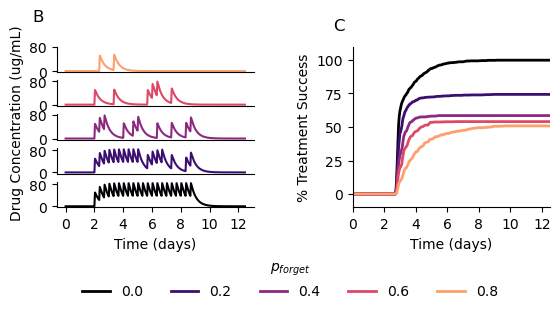

In [2]:
# exp = pickle.load(open(e.experiment_info_path,'rb'))
exp = pickle.load(open('./results/results_03292024_0000/experiment_info_03292024_0000.p','rb'))

resistance_outcome = [1,2]

# exp = pickle.load(open(exp_info_path,'rb'))

data_folder = exp.results_path
exp_info_file = exp.experiment_info_path

exp_folders,exp_info = results_manager.get_experiment_results(exp=exp)

n_sims = exp_info.n_sims
p_drop = exp_info.prob_drops

# fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,2.5))
fig,ax_list = plt.subplots(ncols=2,figsize=(7,2.2))

cmap = plt.cm.get_cmap('magma')

ax = ax_list[1]

pop = exp_info.populations[0]

xticks = np.arange(0,pop.n_timestep,24*8)

km_data = stats.km_curve(exp=exp,resistance_outcome=resistance_outcome)
prop_data1 = stats.n_mut_curve(exp=exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=exp,nmut=3)
prop_data4 = stats.n_mut_curve(exp=exp,nmut=4)

max_idx_dict = stats.most_freq_genotype(exp=exp,mode=None)

tmax = int(pop.n_timestep)

for p_drop in km_data.keys():
    
    exp_dict = km_data[p_drop]

    death_event_times = exp_dict['survival']

    ax = plotter.plot_kaplan_meier(pop,death_event_times,
                                        ax=ax,
                                        n_sims=n_sims,
                                        label=p_drop,
                                        mode='resistant',
                                        t_max=tmax,
                                        linewidth=2,
                                        color=cmap(int(p_drop[2:])/10))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

pad = 0.05

ax.set_ylabel('% Treatment Success')
ax.set_xlabel('Time (days)')

# ax.set_title('Survival of infectious agent',fontsize=12)

ax.set_ylim([-10,110])

ax.set_xticks(xticks)

ax = plotter.x_ticks_to_days(pop,ax)

# ax.set_xlim([xmin,xmax])

ax.legend(frameon=False,fontsize=10,loc=(-1.4,-0.6),title='$p_{forget}$',ncol=5)

ax = ax_list[0]
n_conditions = len(km_data.keys())

cmap = plt.cm.get_cmap('magma')

# xticks = np.arange(0,pop.n_timestep,96)

ax.set_xticks([])
ax.set_yticks([])

ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

indx = 0

axins_list = []

for p in exp_info.populations:

    axins = ax.inset_axes([0,0.2*indx,0.8,0.15])

    axins.plot(p.drug_curve,linewidth=1.5,label='$p_{drop}$ = ' + str(p.prob_drop),
                color=cmap(p.prob_drop))
    
    axins.set_xticks([])
    axins.set_yticks([])

    axins.spines["right"].set_visible(False)
    axins.spines["top"].set_visible(False)
        
    axins_list.append(axins)

    axins.set_yticks([0,80])

    indx+=1

# ax.legend(frameon=False,fontsize=10)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

axins_list[0].set_xlabel('Time (days)')
ax.set_ylabel('Drug Concentration (ug/mL)',labelpad=20)

pos = ax.get_position()

width = pos.width*0.8
height = pos.height*0.95

pos = ax_list[1].get_position()
pos.y1 = pos.y0 + height
pos.x1 = pos.x0 + width

ax_list[1].set_position(pos)

xt = np.array([0,2,4,6,8,10,12])*24
ax_list[1].set_xticks(xt)

ax_list[1].set_xticklabels([str(int(x/24)) for x in xt])

axins_list[0].set_xticks(xt)
axins_list[0].set_xticklabels([str(int(x/24)) for x in xt])

ax_list[0].annotate('B',xy=(-0.1,1.1),xycoords='axes fraction',fontsize=12)
ax_list[1].annotate('C',xy=(-0.1,1.1),xycoords='axes fraction',fontsize=12)

fig.savefig('../figures/nonadherence_km.pdf',bbox_inches='tight')

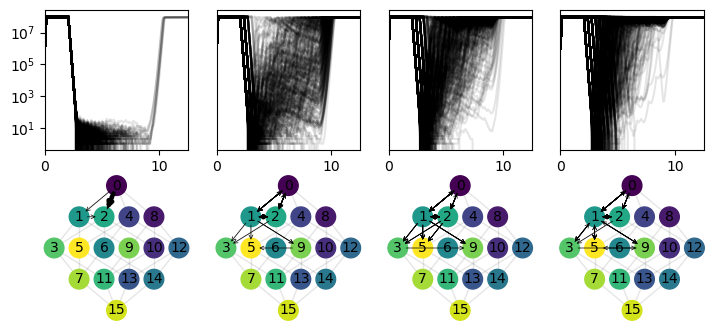

In [3]:
n_conditions = len(km_data.keys())
fig,ax_list = plt.subplots(nrows=2,ncols=n_conditions-1,figsize=(8.5,4),
                            sharex=False,sharey=False)

# exp = pickle.load(open('./results/results_03082024_0002/experiment_info_03082024_0002.p','rb'))
# exp = pickle.load(open(e.experiment_info_path,'rb'))
arrowprops = dict(arrowstyle='->', color='black', lw=1.5,mutation_scale=7,shrinkA=6,shrinkB=6)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

cmap = plt.get_cmap('Accent')

keys = list(prop_data1.keys())[:-1]

p = e.populations[0]

for indx,key in enumerate(keys):
    
    ax = ax_list[0,indx]

    for sim_num in range(n_sims):
        y = stats.get_population_timetrace(sim_num=sim_num,condition_num=indx,exp=exp)
        ax.plot(y,color='black',alpha=0.1)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,p.n_timestep,24*10))
    ax = plotter.x_ticks_to_days(p,ax)

    ax.set_yticks([])

    ax = ax_list[1,indx]
    traj_list = []
    for sim_num in range(n_sims):
        
        data = stats.get_sim_data(sim_num=sim_num,condition_num=indx,exp=exp)

        if np.sum(data[-1,:]) > 0:

            trajectory = [0]
            for t in range(len(data[:,0])):
                pop = data[t,:]
                max_gen = np.argmax(pop)
                if max_gen != trajectory[-1]:
                    trajectory.append(max_gen)

            if len(trajectory) > 1:
                traj_list.append(trajectory)

    # count the number of each unique trajectory
    
    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  
    
    traj_list_count = np.zeros((len(traj_list_unique)))
    
    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    traj_list_count = 5*(np.array(traj_list_count)/np.sum(traj_list_count))**2

    traj_list_count[traj_list_count < 0.5] = 0.5
    

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.mean(p.drug_curve),ax=ax,
                           colorbar=False,weight_list=traj_list_count,**landscape_options)
    
yt = [10**1,10**3,10**5,10**7]

ax_list[0,0].set_yticks(yt)

xticks = np.arange(0,p.n_timestep,24*8)


    ###########################################################################

# fig.savefig('figures/nonadherence_grid.pdf',bbox_inches='tight')

In [4]:
def compute_doses(regimen,pop):

    dose_schedule = pop.dose_schedule/pop.timestep_scale
    n_doses = int(np.floor(pop.regimen_length/dose_schedule))

    doses = np.zeros(n_doses)

    dose_num = 0

    for i in range(n_doses):
        if regimen[int(i*dose_schedule)] == 1:
            doses[dose_num] = 1
        dose_num += 1
    
    return doses

0.21079691516709512
0.2616822429906542


0.33405172413793105
0.43018867924528303


0.518348623853211
0.6684397163120568


0.624561403508772
0.8573426573426574




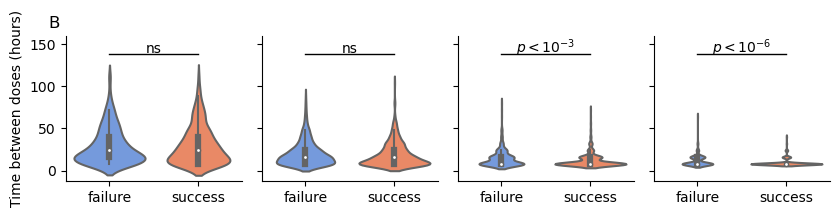

In [6]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.2),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    # ax = ax_list[num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1

    ax = ax_list[num]

    time_between_surv = []
    time_between_ext = []

    for s in survived_sched:
        # print(s)
        doses = np.argwhere(s==1)
        if len(doses) > 1:
            time_between_surv.append((doses[1]-doses[0])[0]*p.dose_schedule)
            
    for ext in extinct_sched:
        doses = np.argwhere(ext==1)
        if len(doses) > 1:
            time_between_ext.append((doses[1]-doses[0])[0]*p.dose_schedule)

    d = {'survived':time_between_surv,
            'extinct':time_between_ext}
    
    sns.violinplot(ax=ax,data=[time_between_surv,time_between_ext],
                    palette=['cornflowerblue','coral'],alpha=0.1)
    
    # display a horizontal line over the violin plot

    ax.plot([0,1],[138,138],'k',linewidth=1)

    t_stat,p_val = spstats.ttest_ind(time_between_surv,time_between_ext,equal_var=False)

    if p_val < 0.05:

        log_val = str(round(np.log10(p_val)) + 1)

        ax.text(0.5,140,'$p < 10^{' + log_val + '}$',fontsize=10,ha='center')

    else:
        ax.text(0.5,140,'ns',fontsize=10,ha='center')
    
    # ax.tight_layout()
    xt = ax.get_xticks()
    ax.set_xticks(xt)
    ax.set_xticklabels(['failure','success'])

    # ax.set_yticks([0,5,10,15,20])
    # ax.set_ylim(0,12)
    yl = ax.get_ylim()
    ax.set_ylim([yl[0],160])

    # ax.tick_params(axis='x', labelsize=12)
    # ax.tick_params(axis='y', labelsize=12)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    time_between_surv = np.array(time_between_surv)

    time_between_ext = np.array(time_between_ext)

    print(len(np.argwhere(time_between_surv == 8))/len(time_between_surv))

    print(len(np.argwhere(time_between_ext == 8))/len(time_between_ext))
    print('\n')

    # ax.set_yscale('log')

    num+=1

ax_list[0].set_ylabel('Time between doses (hours)')
ax_list[0].annotate('B',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

fig.tight_layout()

fig.savefig('../figures/nonadherence_violin.pdf',bbox_inches='tight')

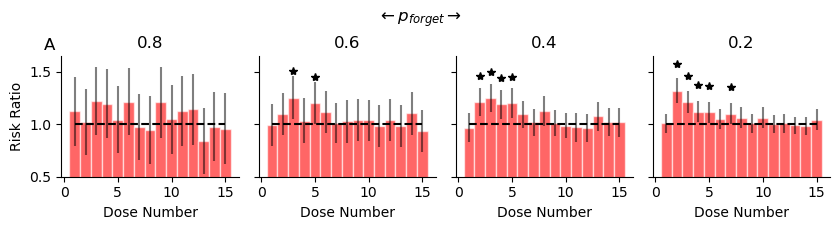

In [7]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.5),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    # ax = ax_list[num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1

    ax = ax_list[num]

    ratio = np.divide(extinct_hist,survived_hist)

    ax.bar(dose_num,ratio,width=1,color='red',alpha=0.6,edgecolor='w',
        align='center')
    
    ax.plot(dose_num,np.ones(len(dose_num)),'--',color='black')

    conf_int = np.zeros(len(survived_hist))
    for i in range(len(survived_hist)):
        conf_int[i] = conf_interval(n_survived,survived_hist[i]*n_survived,
                                    n_extinct,extinct_hist[i]*n_extinct)

    ax.errorbar(dose_num,ratio,yerr=conf_int,fmt='none',ecolor='k',
                capsize=0,alpha=0.5)
    
    significant_indx = np.argwhere(ratio - conf_int > 1)

    if len(significant_indx) > 0:
        ax.plot(significant_indx+1,ratio[significant_indx] + 0.25,'*',color='black')

    ax.set_ylim([0.5,1.65])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel('Dose Number')
    ax.set_title(p_drop_t,fontsize=12)

    num+=1

ax_list[0].set_ylabel('Risk Ratio')

ax_list[0].annotate('A',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

fig.suptitle(r'$\leftarrow p_{forget} \rightarrow$',y=0.9)

fig.tight_layout()

fig.savefig('../figures/nonadherence_risk_ratio.pdf',bbox_inches='tight')
fig.savefig('../figures/nonadherence_risk_ratio.png',bbox_inches='tight',dpi=500)

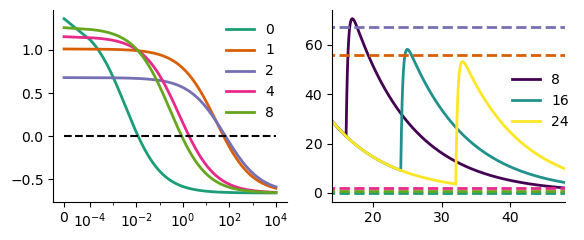

In [8]:
# MSW analysis
from fears.utils import fitness

fig,ax_list = plt.subplots(ncols=2,figsize=(6,2.5))

p = exp_info.populations[0]

c = np.logspace(-4,4,1000)

# append zero to the left of the array
c = np.append(0,c)

cmap = plt.cm.get_cmap('Dark2')
ax = ax_list[0]
for i,g in enumerate([0,1,2,4,8]):

    y = fitness.gen_fitness(p,g,c)
    ax.plot(c,y,label=str(g),linewidth=2,color=cmap(i))

ax.set_xscale('symlog',linthresh=10**-4)

ax.plot([0,10**4],[0,0],'--',color='black')

ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xticks([0,10**-4,10**-2,10**0,10**2,10**4])

ax = ax_list[1]

t = np.linspace(0,48,1000)
indx0 = np.argwhere(t>=8)[0][0]

c = pharm.pharm_eqn(p,t)

cmap = plt.cm.get_cmap('viridis')
for i,spacing in enumerate([8,16,24]):
    u = np.zeros(len(t))
    u[indx0] = 1

    indx1 = np.argwhere(t>=spacing)[0][0] + indx0
    u[indx1] = 1

    y = np.convolve(c,u,mode='full')

    ax.plot(t,y[:len(t)],label=str(spacing),linewidth=2,color=cmap(i/2))

cmap = plt.cm.get_cmap('Dark2')
for i,g in enumerate([0,1,2,4,8]):
    mic = p.seascape_lib[str(g)]['mic']

    ax.plot([0,48],[mic,mic],'--',color=cmap(i),linewidth=2)

ax.set_xlim(14,48)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.legend(frameon=False,loc=(0.75,0.35))

fig.tight_layout()


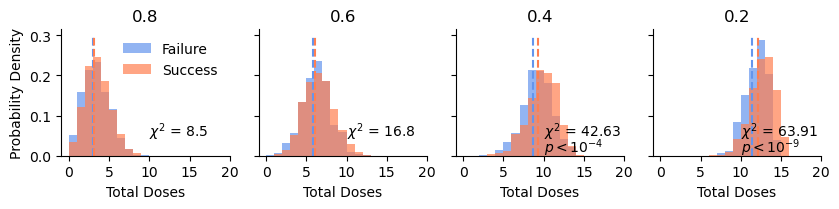

In [9]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.2),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

pval_list = []

for exp in exp_folders_t:

    # ax = ax_list[num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1

    ax = ax_list[num]

    total_doses_surv = np.sum(survived_sched,axis=1)
    total_doses_ext = np.sum(extinct_sched,axis=1)

    d = {'survived':total_doses_surv,
            'extinct':total_doses_ext}
    
    ax.hist(total_doses_surv,bins=range(0,20),alpha=0.7,color='cornflowerblue',
            label='Failure',density=True)
    
    hist_surv,bins = np.histogram(total_doses_surv,bins=range(0,20))

    ax.hist(total_doses_ext,bins=range(0,20),alpha=0.7,color='coral',
            label='Success',density=True)
    
    hist_ext,bins = np.histogram(total_doses_ext,bins=range(0,20))
    
    ax.plot([np.mean(total_doses_surv),np.mean(total_doses_surv)],[0,0.3],'--',color='cornflowerblue')
    ax.plot([np.mean(total_doses_ext),np.mean(total_doses_ext)],[0,0.3],'--',color='coral')

    tot = hist_surv + hist_ext

    nonzero_indx = np.argwhere(tot > 0)[:,0]

    # remove zero values from the histograms
    hist_surv = hist_surv[nonzero_indx]
    hist_ext = hist_ext[nonzero_indx]

    contingency_table = np.array([hist_surv,hist_ext])
    
    res = spstats.chi2_contingency(contingency_table)

    if res.pvalue < 0.05:
            
            log_val = str(round(np.log10(res.pvalue)) + 1)

            if log_val == '0':
                ax.text(10,0.01,'$p < 0.05$',fontsize=10,ha='left')
            else:
                ax.text(10,0.01,'$p < 10^{' + log_val + '}$',fontsize=10,ha='left')

            # annotate chi squred value
    
    ax.text(10,0.05,'$\chi^2$ = ' + str(round(res.statistic,2)),fontsize=10,ha='left')
    

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # ax.set_yscale('log')

    ax.set_title(p_drop_t)

    num+=1

ax_list[0].set_ylabel('Probability Density')

for ax in ax_list:
    ax.set_xlabel('Total Doses')
    
    ax.set_xticks([0,5,10,15,20])

ax_list[0].legend(frameon=False)

fig.tight_layout()

fig.savefig('../figures/total_doses_hist.pdf',bbox_inches='tight')

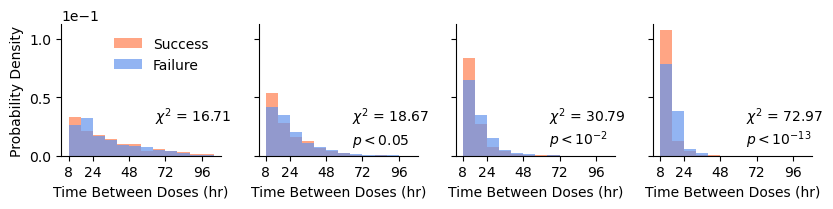

In [10]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

p = exp_info.populations[0]

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.2),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    # ax = ax_list[num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1

    ax = ax_list[num]

    time_between_surv = []
    time_between_ext = []

    for s in survived_sched:
        # print(s)
        doses = np.argwhere(s==1)
        if len(doses) > 1:
            time_between_surv.append((doses[1]-doses[0])[0]*p.dose_schedule)
            
    for ext in extinct_sched:
        doses = np.argwhere(ext==1)
        if len(doses) > 1:
            time_between_ext.append((doses[1]-doses[0])[0]*p.dose_schedule)

    d = {'survived':time_between_surv,
            'extinct':time_between_ext}

    binmax = np.max([np.max(time_between_surv),np.max(time_between_ext)])    

    ax.hist(time_between_ext,bins=range(8,binmax,8),alpha=0.7,color='coral',
        label='Success',density=True)
    
    hist_ext,bins = np.histogram(time_between_ext,bins=range(8,100,8))

    ax.hist(time_between_surv,bins=range(8,binmax,8),alpha=0.7,color='cornflowerblue',
            label='Failure',density=True)
    
    hist_surv,bins = np.histogram(time_between_surv,bins=range(8,100,8))


    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    hist_surv = np.array(hist_surv)

    hist_ext = np.array(hist_ext)

    tot = hist_surv + hist_ext

    if any(tot == 0):
        zero_indx = np.argwhere(tot == 0)[0][0]
    else:
        zero_indx = len(tot)

    contingency_table = np.array([hist_surv[:zero_indx],hist_ext[:zero_indx]])

    res = spstats.chi2_contingency(contingency_table)

    if res.pvalue < 0.05:
            
            log_val = str(round(np.log10(res.pvalue)) + 1)

            if log_val == '0':
                ax.text(65,0.01,'$p < 0.05$',fontsize=10,ha='left')
            else:
                ax.text(65,0.01,'$p < 10^{' + log_val + '}$',fontsize=10,ha='left')

            # annotate chi squred value
    
    ax.text(65,0.03,'$\chi^2$ = ' + str(round(res.statistic,2)),fontsize=10,ha='left')

    # ax.set_title(p_drop_t)

    num+=1

ax_list[0].set_ylabel('Probability Density')
for ax in ax_list:
    ax.set_xlabel('Time Between Doses (hr)')
    
    ax.set_xticks([8,24,48,72,96])

    # ax.set_xlim([8,48])

ax_list[0].legend(frameon=False)

ax_list[0].ticklabel_format(axis='y',style='sci',scilimits=(0,0))

# ax_list[0].annotate('B',xy=(-0.1,1.05),xycoords='axes fraction',fontsize=12)

fig.tight_layout()

fig.savefig('../figures/nonadherence_histogram.pdf',bbox_inches='tight')

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_9846/2287710652.py:89: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(time_between_success,time_between_failure)
/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_9846/2287710652.py:89: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(time_between_success,time_between_failure)


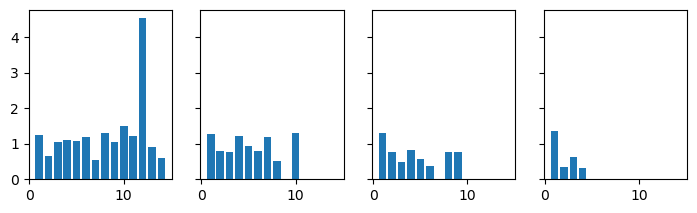

In [61]:
import scipy.stats as spstats

def conf_interval(n1,x1,n2,x2):
    """99% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 99% confidence interval
    """
    return 2.576*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

pop = exp_info.populations[0]

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

p = exp_info.populations[0]

# n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses
n_scheduled_doses = int(np.floor(pop.regimen_length/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,figsize=(8.5,2.2),sharey=True,sharex=True)

exp_folders = np.array(exp_folders)
exp_folders_t = np.flip(exp_folders[[1,2,3,4]])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    ax = ax_list[num]

    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    time_between_success = np.zeros(15)
    n_success = 0
    time_between_failure = np.zeros(15)
    n_failure = 0

    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)

        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array(dose_schedule)

        doses = np.argwhere(dose_schedule == 1)
        
        if len(doses) > 1:
            time_between = doses[1] - doses[0]

            if counts[-1] == 0:
                time_between_success[time_between] += 1
                n_success += 1
            else:
                time_between_failure[time_between] += 1
                n_failure += 1

        k+=1

    time_between_success = time_between_success/n_success
    time_between_failure = time_between_failure/n_failure

    ratio = np.divide(time_between_success,time_between_failure)

    ax.bar(np.arange(15),ratio)

    num+=1



In [49]:
time_between_counts

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])